In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## SDE Simulation:
Suppose we have an SDE which needs to be solved via numerical simulation:


$d X(t) = b(X_t, t) dt + \sigma(X_t, t) d W_t$

* Euler:    

$X_{i+1} = X_i + b(X_i, t_i) (t_{i+1} - t_i) + \sigma(X_i, t_i) (W_{i+1} - W_i)$

* Milstein:

$X_{i+1} = X_i + b(X_i, t_i) (t_{i+1} - t_i) + \sigma(X_i, t_i) (W_{i+1} - W_i) + \frac{1}{2} \sigma(X_i, t_i) \sigma_x(X_i, t_i) \left( (W_{i+1} - W_{i})^2 - (t_{i+1} - t_{i}) \right)$

In [19]:
def SDE(t0,T,x0,N_t,drift,sigma,dsigma, N_sim, method='Euler'):
    assert((method=='Euler') | (method =='Milstein'))
    dt = T/N_t
    t = np.linspace(t0,T,N_t+1)
    sdt = np.sqrt(dt)
    
    Z = np.random.randn(N_sim, N_t)
    X = np.zeros((N_sim, N_t+1))
    X[:,0] = x0
    
    if method == 'Euler':
        for i in range(N_t):
            X[:,i+1] = X[:,i] + drift(X[:,i],t[i])*dt + sigma(X[:,i],t[i])*sdt*Z[:,i]
    else:   #Milstein
        for i in range(N_t):
            X[:,i+1] = X[:,i] + drift(X[:,i],t[i])*dt + sigma(X[:,i],t[i])*sdt*Z[:,i] + 0.5*sigma(X[:,i],t[i])*dsigma(X[:,i],t[i])*(Z[:,i]**2 - 1)*dt
    return (t,X)

# CIR process:  
    
$d X_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}d W_t$
    
Here drift function $b(x,t) = \theta_1 - \theta_2 x$,  volatility function $\sigma(x,t) = \theta_3 \sqrt{x}$, $\frac{\partial \sigma}{\partial x} (x,t)= \frac{\theta_3 }{2\sqrt{x}}$

In [3]:
def drift_CIR(x,t,theta1=6, theta2=3):
    return theta1 - theta2*x

In [4]:
def vol_CIR(x,t,theta3=2):
    return theta3*np.sqrt(np.maximum(x,0.0001))

In [5]:
def d_vol_CIR(x,t,theta3=3):
    return theta3*0.5/np.sqrt(np.maximum(x,0.0001))

In [6]:
t,sim_X=SDE(t0=0,T=1,x0=10,N_t=100,drift=drift_CIR,sigma=vol_CIR,dsigma=d_vol_CIR, N_sim=5000, method='Euler')

### plot sample path of simulated SDE

Text(0.5, 1.0, 'Sample paths for CIR Genearted using Euler scheme')

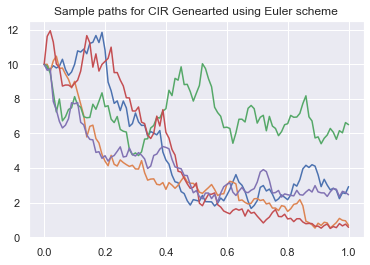

In [7]:
for i in range(5):
    plt.plot(t,sim_X[i,:])
plt.title('Sample paths for CIR Genearted using Euler scheme')

In [8]:
t,sim_X_mil=SDE(t0=0,T=1,x0=10,N_t=100,drift=drift_CIR,sigma=vol_CIR,dsigma=d_vol_CIR, N_sim=5000, method='Milstein')

Text(0.5, 1.0, 'Sample paths for CIR Genearted using Milstein scheme')

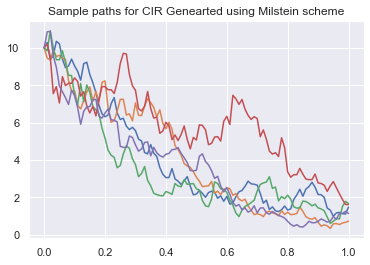

In [9]:
for i in range(5):
    plt.plot(t,sim_X_mil[i,:])
plt.title('Sample paths for CIR Genearted using Milstein scheme')

In [10]:
def sample_nc_chi2_CIR(x0,theta1,theta2,theta3,T,n_sample):
    c = 2*theta2/((theta3**2)*(1 - np.exp(-theta1*T)))
    ncp = 2*c*x0*np.exp(-theta2*T)
    df = 4*theta1/(theta3**2)
    return np.random.noncentral_chisquare(df, ncp, n_sample)/(2*c)

In [11]:
nc_samples=sample_nc_chi2_CIR(x0=10,theta1=6,theta2=3,theta3=2,T=1,n_sample=5000)

In [12]:
sde_sample_mil=sim_X_mil[:,-1]
sde_sample_eul=sim_X[:,-1]
x=np.vstack([nc_samples,sde_sample_eul,sde_sample_mil]).T

In [13]:
x.shape

(5000, 3)

Text(0.5, 1.0, 'Distribution of SDE simulated values (terminal)')

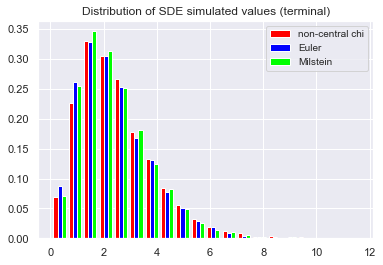

In [14]:
n_bins = 20

colors = ['red', 'blue', 'lime']
labels = ['non-central chi','Euler','Milstein']
plt.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
plt.legend(prop={'size': 10})
plt.title('Distribution of SDE simulated values (terminal)')

## Two-sample KS test for Euler against exact non-central chi-square

In [15]:
from scipy import stats

In [16]:
stats.ks_2samp(nc_samples, sde_sample_eul)

KstestResult(statistic=0.0394, pvalue=0.0008503304486502242)

In [17]:
stats.ks_2samp(nc_samples, sde_sample_mil)

KstestResult(statistic=0.0352, pvalue=0.004075699259476923)

## Conclusion: due to the high p-value we can't reject the null hypothisis and therefore conclude that the distributions simulated by SDE are indistinguishable from the true non-central chi-square distribution